<a href="https://colab.research.google.com/github/sravangvm/Omdena_Project/blob/main/HOT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [80]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img

import numpy as np
from sklearn.utils import shuffle

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import cv2

import os

In [4]:
image_path1='/content/gdrive/MyDrive/data/from_hot/1/'
image_path2='/content/gdrive/MyDrive/data/from_hot/2/'
image_path3='/content/gdrive/MyDrive/data/from_hot/3/'
image_path4='/content/gdrive/MyDrive/data/from_hot/4/'
image_path5='/content/gdrive/MyDrive/data/from_hot/5/'
all_image_paths = [[image_path1+file for file in os.listdir(image_path1)]+[image_path2+file for file in os.listdir(image_path2)]+[image_path3+file for file in os.listdir(image_path3)]+[image_path4+file for file in os.listdir(image_path4)]+[image_path5+file for file in os.listdir(image_path5)]][0]

In [5]:
label_path1='/content/gdrive/MyDrive/data/rasterized_labels/1/'
label_path2='/content/gdrive/MyDrive/data/rasterized_labels/2/'
label_path3='/content/gdrive/MyDrive/data/rasterized_labels/3/'
label_path4='/content/gdrive/MyDrive/data/rasterized_labels/4/'
label_path5='/content/gdrive/MyDrive/data/rasterized_labels/5/'

all_masks_paths=[[label_path1+file for file in os.listdir(label_path1)]+[label_path2+file for file in os.listdir(label_path2)]+[label_path3+file for file in os.listdir(label_path3)]+[label_path4+file for file in os.listdir(label_path4)]+[label_path5+file for file in os.listdir(label_path5)]][0]

In [6]:
all_images_paths=[]
for images in all_image_paths:
  if(images.endswith('.png')):
    all_images_paths.append(images)

In [7]:
len(all_images_paths)

162

In [8]:
all_images_paths=sorted(all_images_paths)

In [9]:
all_masks_paths=sorted(all_masks_paths)

In [10]:
all_images_paths[0:5]

['/content/gdrive/MyDrive/data/from_hot/1/OAM-319305-270982-19.png',
 '/content/gdrive/MyDrive/data/from_hot/1/OAM-319305-270983-19.png',
 '/content/gdrive/MyDrive/data/from_hot/1/OAM-319305-270984-19.png',
 '/content/gdrive/MyDrive/data/from_hot/1/OAM-319305-270985-19.png',
 '/content/gdrive/MyDrive/data/from_hot/1/OAM-319306-270982-19.png']

In [11]:
all_masks_paths[0:5]

['/content/gdrive/MyDrive/data/rasterized_labels/1/OAM-319305-270982-19-label.png',
 '/content/gdrive/MyDrive/data/rasterized_labels/1/OAM-319305-270983-19-label.png',
 '/content/gdrive/MyDrive/data/rasterized_labels/1/OAM-319305-270984-19-label.png',
 '/content/gdrive/MyDrive/data/rasterized_labels/1/OAM-319305-270985-19-label.png',
 '/content/gdrive/MyDrive/data/rasterized_labels/1/OAM-319306-270982-19-label.png']

In [12]:
IMAGE_SIZE = 256

def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = np.mean(image, axis=-1)/255.0
        images.append(image)
    return np.array(images)

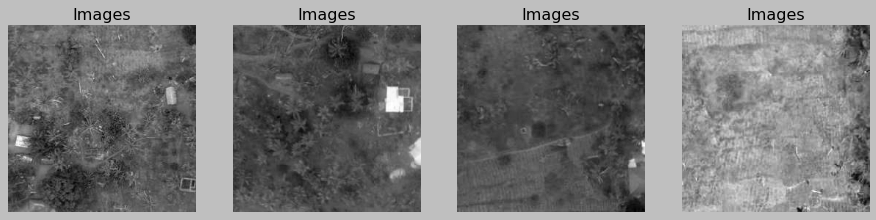

In [118]:
fig = plt.figure(figsize=(32, 32))
for i in range(1,5):
  fig.add_subplot(3,9,i)
  plt.axis('off')
  plt.title('Images')
  plt.imshow(open_images([all_images_paths[i-1]])[0], cmap='gray')
plt.show()

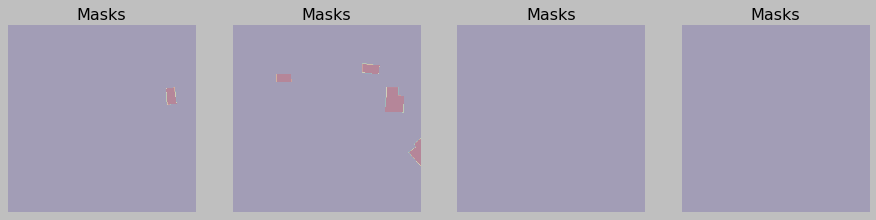

In [83]:
fig = plt.figure(figsize=(32, 32))
for i in range(1,5):
  fig.add_subplot(3,9,i)
  plt.axis('off')
  plt.title('Masks')
  plt.imshow(open_images([all_masks_paths[i-1]])[0], cmap='Spectral_r', alpha=0.3)
plt.show()

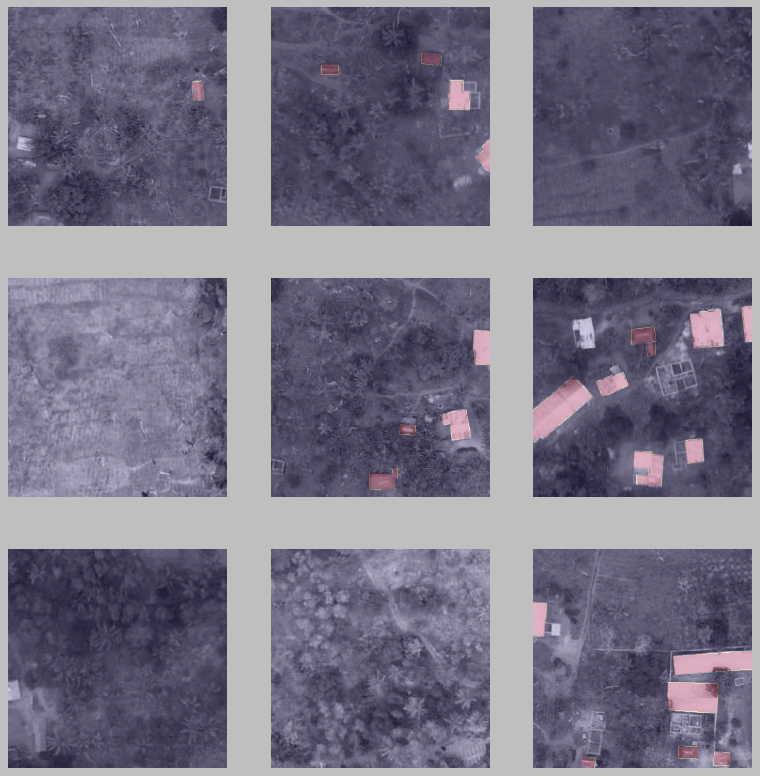

In [84]:
fig = plt.figure(figsize=(12, 12))
c = 3
r = 3
for i in range(1, c*r +1):
    fig.add_subplot(r, c, i)
    plt.axis('off')
    plt.imshow(open_images([all_images_paths[i-1]])[0], cmap='gray')
    plt.imshow(open_images([all_masks_paths[i-1]])[0], cmap='Spectral_r', alpha=0.3)
plt.show()

In [100]:
train_image_paths = all_images_paths[:120]
train_mask_paths = all_masks_paths[:120]
val_image_paths = all_images_paths[120:]
val_mask_paths = all_masks_paths[120:]

def datagen(image_paths, mask_paths, batch_size=16):
    for x in range(0, len(image_paths), batch_size):
        images = open_images(image_paths[x:x+batch_size]).reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1)
        masks = open_images(mask_paths[x:x+batch_size]).reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1)
        yield images, masks

In [51]:
img_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

x1 = Conv2D(64, (3,3), activation='relu', padding='same')(img_input)
x1 = Conv2D(64, (3,3), activation='relu', padding='same')(x1)
x1_pool = MaxPool2D((2,2))(x1)

x2 = Conv2D(128, (3,3), activation='relu', padding='same')(x1_pool)
x2 = Conv2D(128, (3,3), activation='relu', padding='same')(x2)
x2_pool = MaxPool2D((2,2))(x2)

x3 = Conv2D(256, (3,3), activation='relu', padding='same')(x2_pool)
x3 = Conv2D(256, (3,3), activation='relu', padding='same')(x3)
x3 = Conv2D(256, (3,3), activation='relu', padding='same')(x3)
x3_pool = MaxPool2D((2,2))(x3)

x4 = Conv2D(256, (3,3), activation='relu', padding='same')(x3_pool)
x4 = Conv2D(256, (3,3), activation='relu', padding='same')(x4)
x4 = Conv2D(256, (3,3), activation='relu', padding='same')(x4)
x4_pool = UpSampling2D((2,2))(x4)

x5 = Concatenate()([x4_pool, x3])
x5 = Conv2D(128, (3,3), activation='relu', padding='same')(x5)
x5 = Conv2D(128, (3,3), activation='relu', padding='same')(x5)
x5_pool = UpSampling2D((2,2))(x5)

x6 = Concatenate()([x5_pool, x2])
x6 = Conv2D(64, (3,3), activation='relu', padding='same')(x6)
x6 = Conv2D(64, (3,3), activation='relu', padding='same')(x6)
x6_pool = UpSampling2D((2,2))(x6)

x7 = Concatenate()([x6_pool, x1])
x7 = Conv2D(64, (3,3), activation='relu', padding='same')(x7)
x7 = Conv2D(64, (3,3), activation='relu', padding='same')(x7)
x7 = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x7)

model = Model(img_input, x7)

In [86]:
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=[iou_coef,"accuracy"])

In [101]:
batch_size = 1
steps = 5
epochs = 2
for _ in range(epochs):
    model.fit(datagen(train_image_paths, train_mask_paths, batch_size=batch_size), epochs=1, steps_per_epoch=steps)

5/5 [==============================] - 0s 40ms/step - loss: 0.6369 - iou_coef: 0.0121 - accuracy: 0.9854


In [107]:
batch_size = 3
steps = 5
model.evaluate(datagen(val_image_paths, val_mask_paths, batch_size=batch_size), steps=steps)

5/5 [==============================] - 0s 53ms/step - loss: 0.5839 - iou_coef: 0.0479 - accuracy: 0.9451


[0.5839343667030334, 0.047897420823574066, 0.9451406002044678]

In [148]:
i = open_images(val_image_paths)
j = open_images(val_mask_paths)
k =  model.predict(open_images(val_image_paths)).reshape(42,256,256)

In [147]:
open_images(val_mask_paths).shape

(42, 256, 256)

In [149]:
k.shape

(42, 256, 256)

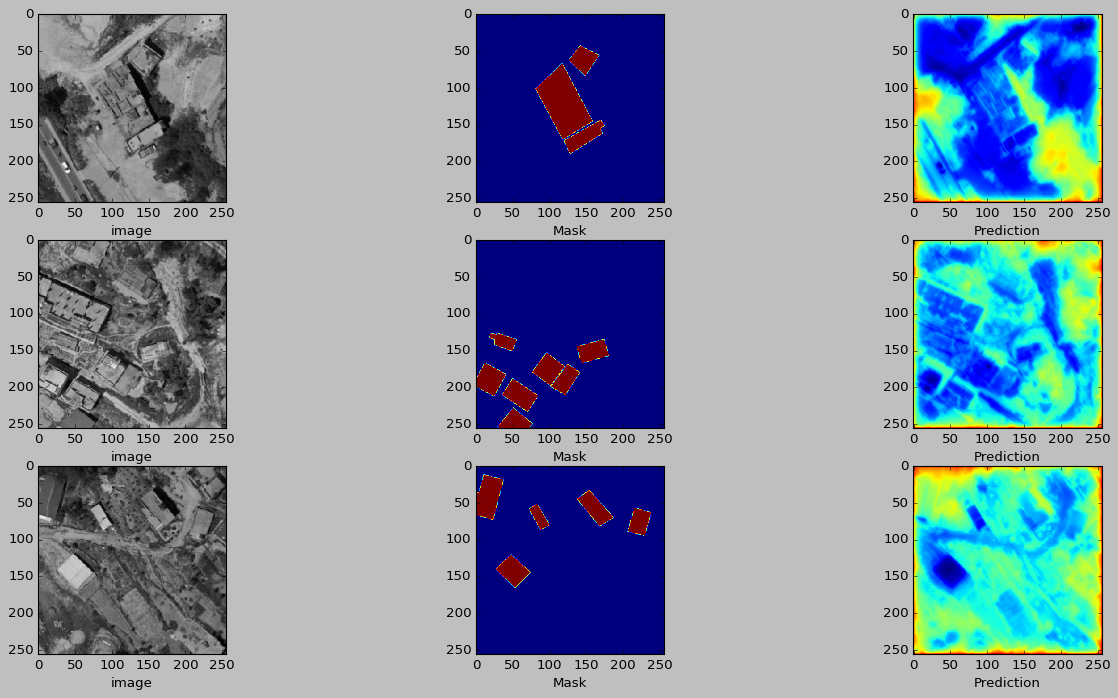

In [154]:
plt.figure(figsize=(20,10))
for x in range(0,9,3):
    plt.subplot(3,3,x+1)
    
    plt.xlabel("image")
    plt.imshow(np.squeeze(i[x]),cmap='gray')
     
    
    plt.subplot(3,3,x+2)
    plt.xlabel("Mask")
    plt.imshow(np.squeeze(j[x]))
        
    plt.subplot(3,3,x+3)
    plt.xlabel("Prediction")
    plt.imshow(np.squeeze(k[x]))